In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


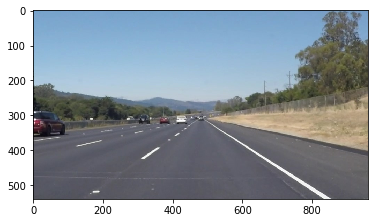

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def calc_regression_line(lines_params):
    """
    'lines_params' parameters (slope and intercept) of all lines that need to be extrapolated
    lines_params is an array [[slope1,intercept1], [slope2,intercept2]....]
    Returns the regression line parameters (slope and y-intercept)
    """
    
    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = []
    for line_params in lines_params:
        slopes.append(line_params[0])
        
    slope_mean = np.mean(slopes)
    slope_std = np.std(slopes)
    
    #arrays for the remained slopes and intercepts after filtering out the deviated ones
    remain_slopes = []
    remain_intercepts = []
    
    for line_params in lines_params:
        slope = line_params[0]
        
        if (slope - slope_mean) < (1.2 * slope_std):
            remain_slopes.append(slope)
            remain_intercepts.append(line_params[1])
            
    if not remain_slopes:
        remain_slopes = slopes
        for line_params in lines_params:
            remain_intercepts.append(line_params[1] )
            
    # Calculate the slope mean and intercept mean of the remaining values
    slope = np.mean(remain_slopes)
    intercept = np.mean(remain_intercepts)
    
    return slope, intercept

def draw_lines(img, lines, LANE_MIN_Y, color=[255, 0, 255], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #initialize arrays to save lines parameters in
    positive_slope_lines = []
    negative_slope_lines = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope * x1
            line_length = np.sqrt((y2-y1)**2 + (x2-x1)**2)
            
            #define a line length threshold to be taken into calculation of regression line slope nad intercept
            if line_length > 20:
                if slope < 0 :
                    negative_slope_lines.append([slope, intercept])
                else:
                    positive_slope_lines.append([slope, intercept])
                
    if not positive_slope_lines:
        print('no positive slope lines')
        
    if not negative_slope_lines:
        print('no negative slope lines')
        
        
    #calc two regression lines one for the positive slopes and the other for the negative slopes:
    pos_slope, pos_intercept = calc_regression_line(positive_slope_lines)
    neg_slope, neg_intercept = calc_regression_line(negative_slope_lines)

    #condition to avoid dividing by zero
    if (pos_slope > 0):
        #Calculate the start and end point of the pos slope regression line
        start_pt1 = (int((LANE_MIN_Y - pos_intercept)/pos_slope), int(LANE_MIN_Y))

        end_pt1 = (int((img.shape[0]-pos_intercept)/pos_slope), int(img.shape[0])) #end_pt1 at the lower part of the image

        # Draw pos slope line using cv2.line
        cv2.line(img, start_pt1, end_pt1, color, thickness)
    
    if (neg_slope < 0):
        #Calculate the start and end point of the neg slope regression line
        start_pt2 = (int((LANE_MIN_Y - neg_intercept)/neg_slope), int(LANE_MIN_Y))

        end_pt2 = (int((img.shape[0]-neg_intercept)/neg_slope), int(img.shape[0])) #end_pt2 at the lower part of the image  

        # Draw pos slope line using cv2.line
        cv2.line(img, start_pt2, end_pt2, color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, lane_min_y):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, lane_min_y)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

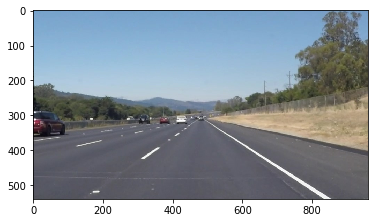

In [4]:
plt.imshow(image)

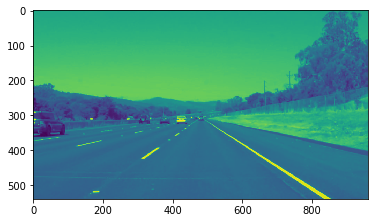

In [5]:
gray = grayscale(image)
plt.imshow(gray)

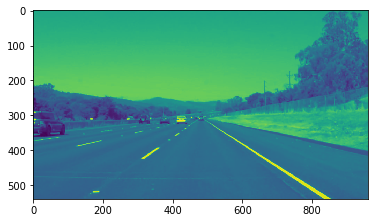

In [6]:
gray = grayscale(image)
plt.imshow(gray)

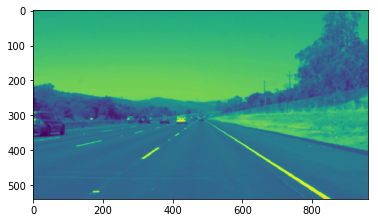

In [7]:
kernel_size = 7
blur_gray = gaussian_blur(gray, kernel_size)
plt.imshow(blur_gray)

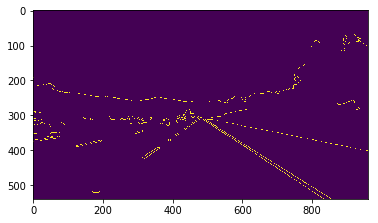

In [8]:
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges)

In [9]:
image.shape

(540, 960, 3)

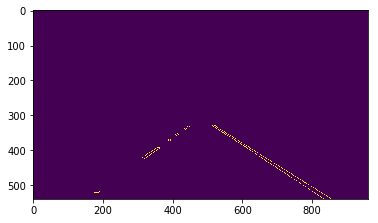

In [10]:
LANE_MIN_Y = 330
vertices = np.array([[(150,image.shape[0]),(420, LANE_MIN_Y), (530, LANE_MIN_Y), (920,image.shape[0])]], dtype=np.int32)
masked_image = region_of_interest(edges, vertices)
plt.imshow(masked_image)

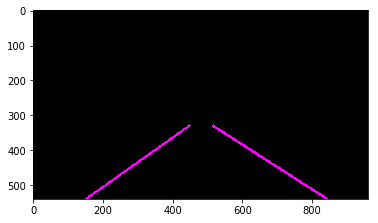

In [11]:
rho = 1
theta = np.pi/180
threshold = 15
min_line_len = 10
max_line_gap = 5
lines_image = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap, LANE_MIN_Y)
plt.imshow(lines_image)

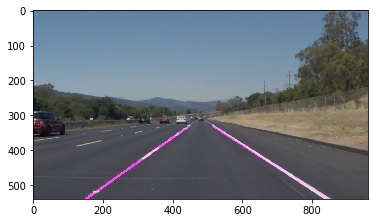

In [12]:
result = weighted_img(lines_image, image)
plt.imshow(result)

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def pipeline(image):
    
    gray = grayscale(image)
    kernel_size = 7
    blur_gray = gaussian_blur(gray, kernel_size)
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    LANE_MIN_Y = 330

    vertices = np.array([[(150,image.shape[0]),(420, LANE_MIN_Y), (530, LANE_MIN_Y), (920,image.shape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)

    rho = 1 
    theta = np.pi/180
    threshold = 15    
    min_line_len = 10
    max_line_gap = 5 

    lines_image = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap, LANE_MIN_Y)
    
    result = weighted_img(lines_image, image)
    
    return result

In [15]:
output = 'output.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:07<00:00, 30.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 7.99 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))